In [3]:
import os
import json
import time
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix
from scipy.spatial import distance
from tqdm import tqdm
from show_graph_until_epoch import * # show_graph_until_epoch.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 최신: GRU 모델을 훈련시킬 때 속도 정보 추가

In [5]:
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]
DR = 'E'
FRAME_INTERVAL = 6
VID_LEN = 600
FRAMES = list(range(0, VID_LEN, FRAME_INTERVAL))
CLASS_LIST = ['Normal', 'Fall', 'Danger']
BATCH_SIZE = 64

def calculate_head_upper_body_speed(current_frame, prev_frame):
    h = np.array([current_frame['landmark_0']['x'], current_frame['landmark_0']['y']])
    l = np.array([current_frame['landmark_11']['x'], current_frame['landmark_11']['y']])
    r = np.array([current_frame['landmark_12']['x'], current_frame['landmark_12']['y']])
    
    prev_h = np.array([prev_frame['landmark_0']['x'], prev_frame['landmark_0']['y']])
    prev_l = np.array([prev_frame['landmark_11']['x'], prev_frame['landmark_11']['y']])
    prev_r = np.array([prev_frame['landmark_12']['x'], prev_frame['landmark_12']['y']])
    
    center_new = (h + l + r) / 3
    center_prev = (prev_h + prev_l + prev_r) / 3
    
    return distance.euclidean(center_new, center_prev)

class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.class_mapping = {0: 'Normal', 1: 'Fall', 2: 'Danger'}
        
        all_landmarks = []
        for json_file in tqdm(json_files, desc="Processing JSON files"):
            try:
                with open(json_file, 'r') as f:
                    data = json.load(f)
                frames = list(data['pose_data'].values())
                fall_start = data.get('fall_start_frame', None)
                fall_end = data.get('fall_end_frame', float('inf'))
                
                for i in range(0, len(frames) - self.sequence_length + 1):
                    sequence = frames[i:i+self.sequence_length]
                    landmarks = []
                    for j, frame in enumerate(sequence):
                        frame_landmarks = []
                        for landmark in LANDMARKS:
                            if f'landmark_{landmark}' not in frame:
                                print(f"Missing landmark {landmark} in frame")
                                continue
                            frame_landmarks.extend([
                                frame[f'landmark_{landmark}']['x'],
                                frame[f'landmark_{landmark}']['y']
                            ])
                        
                        bbox = frame.get('bbox')
                        if bbox:
                            frame_landmarks.extend([
                                bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
                            ])
                        else:
                            frame_landmarks.extend([0, 0, 1, 1])
                        
                        if j > 0:
                            head_torso_speed = calculate_head_upper_body_speed(sequence[j], sequence[j-1])
                        else:
                            head_torso_speed = 0.0
                        frame_landmarks.append(head_torso_speed)
                        
                        landmarks.append(frame_landmarks)
                    
                    last_frame_index = i + self.sequence_length - 1
                    if fall_start is not None and fall_end is not None:
                        if fall_start <= last_frame_index < fall_end:
                            label = 2  # Danger
                        elif last_frame_index >= fall_end:
                            label = 1  # Fall
                        else:
                            label = 0  # Normal
                    else:
                        label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Fall' else 2)
                    
                    self.sequences.append(landmarks)
                    self.labels.append(label)
                    all_landmarks.extend(landmarks)
            except Exception as e:
                print(f"Error processing file {json_file}: {e}")
                continue
        
        if not self.sequences:
            raise ValueError("No valid sequences found in the dataset")
        
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        print(f"Total sequences: {len(self.sequences)}")
        print(f"Labels distribution: {np.bincount(self.labels)}")
        print(f"Sequence shape: {self.sequences[0].shape}")
        print(f"Features per frame: {self.sequences[0].shape[1]}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=3, dropout=0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out
    
class GRU_deep(nn.Module):
    def __init__(self, input_size):
        super(GRU_deep, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, num_layers=2, batch_first=True)
        self.gru2 = nn.GRU(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.gru3 = nn.GRU(input_size=256, hidden_size=512, num_layers=2, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.gru4 = nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.gru5 = nn.GRU(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
        self.gru6 = nn.GRU(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.gru7 = nn.GRU(input_size=64, hidden_size=32, num_layers=2, batch_first=True)
        self.fc = nn.Linear(32,3)

    def forward(self, x) :
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x = self.dropout1(x)
        x, _ = self.gru4(x)
        x, _ = self.gru5(x)
        x, _ = self.gru6(x)
        x = self.dropout2(x)
        x, _ = self.gru7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x

def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0
    for sequences, labels in tqdm(data_loader, desc="Training"):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        acc = (preds == labels).cpu().float().sum() / len(labels)
        total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader) # train_loss, train_acc

def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for sequences, labels in tqdm(data_loader, desc="Validating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.view(-1))
            total_loss += loss.item()
            acc = (preds == labels).cpu().float().sum() / len(labels)
            total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader) # val_loss, val_acc

def calculate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm



In [8]:
def main():
    data_root = DR + r':\addition_yolobbox_json_6'
    train_json_folder = f'{data_root}\\train'
    val_json_folder = f'{data_root}\\val'  # 검증 데이터셋 폴더 경로
    pt_path = DR + r':\project\CVProject\results\my_model_pt'
    
    train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
    val_json_files = [os.path.join(val_json_folder, f) for f in os.listdir(val_json_folder) if f.endswith('.json')]
    
    train_dataset = FallSequenceDataset(train_json_files)
    val_dataset = FallSequenceDataset(val_json_files)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # 클래스 가중치 계산 (train_dataset의 레이블만 사용)
    train_labels = [label for _, label in train_dataset]
    train_labels = np.array(train_labels, dtype=int)
    unique_classes = np.array([0, 1, 2], dtype=int)  # 모든 가능한 클래스를 명시적으로 지정

    print("train_labels dtype:", train_labels.dtype)
    print("unique_classes dtype:", unique_classes.dtype)
    print("Unique labels in train_labels:", np.unique(train_labels))
    print("unique_classes:", unique_classes)

    class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)

    # 손실 함수에 가중치 적용
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    if len(train_dataset) > 0:
        sample_sequence, sample_label = train_dataset[0]
        input_size = sample_sequence.shape[1]
        print(f'Input size: {input_size}')
        model = FallDetectionGRU(input_size).to(device)
        # model = GRU_deep(input_size).to(device)
    else:
        print("No data available")
        return
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    num_epochs = 150
    best_loss = float('inf')
    patience = 20
    no_improve = 0

    logs = {'epoch': [], 'tloss': [], 'tacc': [], 'vloss': [], 'vacc': [], 'time': []}
    log_stack = []
    
    for epoch in range(num_epochs):
        time_start = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        time_end = time.time()
        time_spent = time_end - time_start

        logs = record_logs(logs, epoch, train_loss, train_acc, val_loss, val_acc, time_spent)
        log_stack = print_log(logs, epoch, num_epochs, log_stack)
        
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\best_detect_GRU_Final_temp.pt')
            print(f"Best model saved: {best_loss:.4f}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break
    
    model.load_state_dict(torch.load(f'{pt_path}\\best_detect_GRU_Final_temp.pt'))
    train_f1, train_cm = calculate_metrics(model, train_loader, device)
    val_f1, val_cm = calculate_metrics(model, val_loader, device)
    
    print(f'Train F1: {train_f1:.4f}')
    print(f'Train CM:\n{train_cm}')
    print(f'Validation F1: {val_f1:.4f}')
    print(f'Validation CM:\n{val_cm}')
    
    print("Training completed")

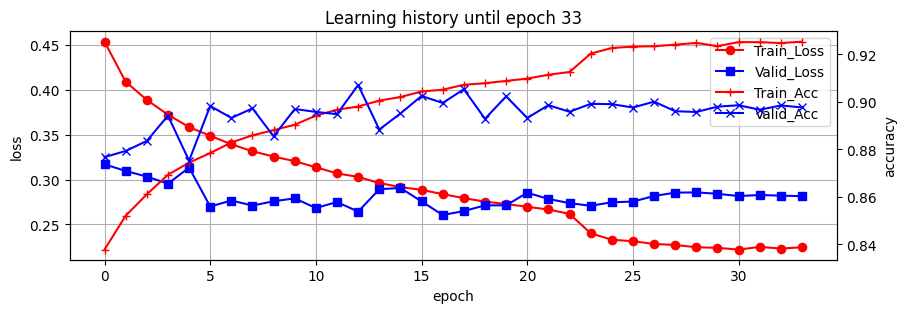

Epoch: 34/150 | T_Loss 0.225 | T_Acc 0.925 | V_Loss 0.281 | V_Acc 0.898 | Time 12.341
Epoch: 33/150 | T_Loss 0.223 | T_Acc 0.925 | V_Loss 0.282 | V_Acc 0.899 | Time 12.475
Epoch: 32/150 | T_Loss 0.225 | T_Acc 0.925 | V_Loss 0.283 | V_Acc 0.897 | Time 11.934
Epoch: 31/150 | T_Loss 0.222 | T_Acc 0.925 | V_Loss 0.282 | V_Acc 0.899 | Time 12.562
Epoch: 30/150 | T_Loss 0.224 | T_Acc 0.924 | V_Loss 0.284 | V_Acc 0.898 | Time 12.097
Epoch: 29/150 | T_Loss 0.225 | T_Acc 0.925 | V_Loss 0.286 | V_Acc 0.896 | Time 12.119
Epoch: 28/150 | T_Loss 0.227 | T_Acc 0.924 | V_Loss 0.285 | V_Acc 0.896 | Time 12.428
Epoch: 27/150 | T_Loss 0.228 | T_Acc 0.923 | V_Loss 0.282 | V_Acc   0.9 | Time 11.849
Epoch: 26/150 | T_Loss 0.231 | T_Acc 0.923 | V_Loss 0.275 | V_Acc 0.898 | Time 11.898
Epoch: 25/150 | T_Loss 0.233 | T_Acc 0.923 | V_Loss 0.275 | V_Acc 0.899 | Time 12.875
Epoch: 24/150 | T_Loss  0.24 | T_Acc  0.92 | V_Loss 0.271 | V_Acc 0.899 | Time 12.624
Epoch: 23/150 | T_Loss 0.262 | T_Acc 0.913 | V_Loss 0.

Training:  38%|███▊      | 2051/5441 [00:04<00:07, 452.89it/s]


KeyboardInterrupt: 

In [9]:
if __name__ == "__main__":
    main()

In [4]:
# 랜드마크 인덱스 정의
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

# 데이터 증강 함수 정의
def augment_sequence(sequence, factor=0.2):
    time_warped = []
    for landmark in sequence:
        x = np.arange(len(landmark))
        f = interp1d(x, landmark, kind='linear', axis=0)
        x_new = np.linspace(0, len(landmark) - 1, num=int(len(landmark) * (1 + factor)))
        time_warped.append(f(x_new))
    return np.array(time_warped)

# 데이터셋 클래스 정의
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        print(f"LANDMARKS length: {len(LANDMARKS)}")
    
        all_landmarks = []
        
        for json_file in json_files:
            print(f'Processing file: {json_file}')
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            frames = list(data['pose_data'].values())
            
            for i in range(0, len(frames) - self.sequence_length + 1):
                sequence = frames[i:i+self.sequence_length]
                landmarks = []
                fall_frames = 0
                
                for frame in sequence:
                    frame_landmarks = []
                    for landmark in LANDMARKS:
                        frame_landmarks.extend([
                            frame[f'landmark_{landmark}']['x'],
                            frame[f'landmark_{landmark}']['y']
                        ])
                    landmarks.append(frame_landmarks)
                    if frame['class'] == 'Fall':
                        fall_frames += 1
                # 데이터 증강 적용        
                augmented_sequence = augment_sequence(landmarks)            
                all_landmarks.extend(augmented_sequence)
                
                # 레이블 재정의
                if fall_frames == 0:
                    label = 0  # 비낙상
                elif fall_frames == self.sequence_length:
                    label = 2  # 완전 낙상
                else:
                    label = 1  # 낙상 위험
                
                self.sequences.append(augmented_sequence)
                self.labels.append(label)
        
        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        if self.sequences:
            print(f"Sample sequence shape: {self.sequences[0].shape}")
        else:
            print("No sequences were created.")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if idx >= len(self.sequences):
            raise IndexError(f"Index {idx} out of range. Dataset length: {len(self.sequences)}")
        sequence = self.sequences[idx]
        return torch.FloatTensor(sequence), torch.LongTensor([self.labels[idx]]).squeeze()

# GRU 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=3, dropout = 0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[ : , -1, :])
        out = self.fc(out)
        return out

# 데이터 로드 및 전처리
json_folder = 'D:\\human_fall\\re_landmark\\re_train_NY_json'
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]
dataset = FallSequenceDataset(json_files)

# 데이터셋을 학습 및 검증 세트로 분할
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# 데이터 로더 생성 전에 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(dataset.labels), y=dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

if len(dataset) > 0:
    sample_sequence, sample_label = dataset[0]
    input_size = sample_sequence.shape[1]
    model = FallDetectionGRU(input_size).to(device)
else:
    print("데이터 없음")
    exit()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 500
best_loss = float('inf')
patience = 50 # 15 이후 다시 실행을 위해 50으로 변경
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss_train = criterion(outputs, labels.view(-1))
        loss_train.backward()
        optimizer.step()
        
        total_loss_train += loss_train.item()
    
    avg_loss_train = total_loss_train / len(train_loader)

    # 검증 단계 추가
    model.eval()
    total_loss_val = 0
    
    with torch.no_grad():
        for sequences_val, labels_val in val_loader:
            sequences_val, labels_val = sequences_val.to(device), labels_val.to(device)
            outputs_val = model(sequences_val)
            loss_val = criterion(outputs_val, labels_val.view(-1))
            total_loss_val += loss_val.item()
    
    avg_loss_val = total_loss_val / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_val:.4f}')
    scheduler.step(avg_loss_val)
    
    if avg_loss_val < best_loss:
        best_loss = avg_loss_val
        no_improve = 0
        torch.save(model.state_dict(), 'try_2.pt')
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping")
        break
    
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

# 학습 루프 내에서 성능 지표 계산
train_f1, train_cm = calculate_metrics(model, train_loader)
val_f1, val_cm = calculate_metrics(model, val_loader)
print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')
print(f'Train CM:\n{train_cm}\nVal CM:\n{val_cm}')

print("Training completed")

LANDMARKS length: 11
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C1.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C2.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C3.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C4.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C5.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C6.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C7.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00060_H_A_SY_C8.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00093_H_A_FY_C1.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00093_H_A_FY_C2.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00093_H_A_FY_C3.json
Processing file: D:\human_fall\re_landmark\re_train_NY_json\00093_H_A_FY_C4.json
Process

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500], Train Loss: 0.7129, Val Loss: 0.6668
Epoch [2/500], Train Loss: 0.6764, Val Loss: 0.6457
Epoch [3/500], Train Loss: 0.6613, Val Loss: 0.6350
Epoch [4/500], Train Loss: 0.6481, Val Loss: 0.6253
Epoch [5/500], Train Loss: 0.6374, Val Loss: 0.6105
Epoch [6/500], Train Loss: 0.6251, Val Loss: 0.5941
Epoch [7/500], Train Loss: 0.6151, Val Loss: 0.5875
Epoch [8/500], Train Loss: 0.6053, Val Loss: 0.5802
Epoch [9/500], Train Loss: 0.5964, Val Loss: 0.5714
Epoch [10/500], Train Loss: 0.5894, Val Loss: 0.5622
Epoch [11/500], Train Loss: 0.5820, Val Loss: 0.5607
Epoch [12/500], Train Loss: 0.5745, Val Loss: 0.5503
Epoch [13/500], Train Loss: 0.5659, Val Loss: 0.5476
Epoch [14/500], Train Loss: 0.5599, Val Loss: 0.5390
Epoch [15/500], Train Loss: 0.5537, Val Loss: 0.5355
Epoch [16/500], Train Loss: 0.5476, Val Loss: 0.5274
Epoch [17/500], Train Loss: 0.5417, Val Loss: 0.5211
Epoch [18/500], Train Loss: 0.5377, Val Loss: 0.5197
Epoch [19/500], Train Loss: 0.5338, Val Loss: 0.5193
Ep

### sensordata를 포함해 클래스를 재정의한 json 파일로 다시 훈련

In [ ]:
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

# 데이터 증강 삭제
# 데이터셋 클래스 정의
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        print(f"LANDMARKS length: {len(LANDMARKS)}")
        
        if self.sequences:
            print(f"sequence shape : {self.sequences[0].shape}")
            print(f"랜드마크 수 : {len(LANDMARKS)}")
            print(f"Features / landmark: {self.sequences[0].shape[1] // len(LANDMARKS)}")
            print(f"전체 features per frame: {self.sequences[0].shape[1]}")
        else:
            print("시퀀스 생성 실패")
    
        all_landmarks = []
        
        for json_file in json_files:
            print(f'Processing file: {json_file}')
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            frames = list(data['pose_data'].values())
            
            for i in range(0, len(frames) - self.sequence_length + 1):
                sequence = frames[i:i+self.sequence_length]
                landmarks = []
                
                for frame in sequence:
                    frame_landmarks = []
                    for landmark in LANDMARKS:
                        frame_landmarks.extend([
                            frame[f'landmark_{landmark}']['x'],
                            frame[f'landmark_{landmark}']['y']
                        ])
                    landmarks.append(frame_landmarks)
                
                all_landmarks.extend(landmarks)
                
                # 마지막 프레임의 클래스를 레이블로 사용
                label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Danger' else 2)
                
                self.sequences.append(landmarks)
                self.labels.append(label)
        
        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        if self.sequences:
            print(f"sequence shape: {self.sequences[0].shape}")
        else:
            print("sequences 생성 실패")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if idx >= len(self.sequences):
            raise IndexError(f"Index {idx} out of range. Dataset length: {len(self.sequences)}")
        sequence = self.sequences[idx]
        return torch.FloatTensor(sequence), torch.LongTensor([self.labels[idx]]).squeeze()

# GRU 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=3, dropout=0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# 데이터 로드 및 전처리
json_folder = 'D:\\human_fall\\re_landmark\\addition_json'
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]
dataset = FallSequenceDataset(json_files)

# 데이터셋을 학습 및 검증 세트로 분할
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# 데이터 로더 생성 전에 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(dataset.labels), y=dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

if len(dataset) > 0:
    sample_sequence, sample_label = dataset[0]
    input_size = sample_sequence.shape[1]
    print(f'input_size :', {input_size})
    model = FallDetectionGRU(input_size).to(device)
else:
    print("데이터 없음")
    exit()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss_train = criterion(outputs, labels.view(-1))
        loss_train.backward()
        optimizer.step()
        
        total_loss_train += loss_train.item()
    
    avg_loss_train = total_loss_train / len(train_loader)

    # 검증 단계
    model.eval()
    total_loss_val = 0
    
    with torch.no_grad():
        for sequences_val, labels_val in val_loader:
            sequences_val, labels_val = sequences_val.to(device), labels_val.to(device)
            outputs_val = model(sequences_val)
            loss_val = criterion(outputs_val, labels_val.view(-1))
            total_loss_val += loss_val.item()
    
    avg_loss_val = total_loss_val / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_val:.4f}')
    scheduler.step(avg_loss_val)
    
    if avg_loss_val < best_loss:
        best_loss = avg_loss_val
        no_improve = 0
        torch.save(model.state_dict(), 'add_sensordata.pt')
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping")
        break

def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

# 학습 루프 내에서 성능 지표 계산
train_f1, train_cm = calculate_metrics(model, train_loader)
val_f1, val_cm = calculate_metrics(model, val_loader)
print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')
print(f'Train CM:\n{train_cm}\nVal CM:\n{val_cm}')

print("학습 완료")

LANDMARKS length: 11
시퀀스 생성 실패
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C1.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C2.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C3.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C4.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C5.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C6.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C7.json
Processing file: D:\human_fall\re_landmark\addition_json\00060_H_A_SY_C8.json
Processing file: D:\human_fall\re_landmark\addition_json\00093_H_A_FY_C1.json
Processing file: D:\human_fall\re_landmark\addition_json\00093_H_A_FY_C2.json
Processing file: D:\human_fall\re_landmark\addition_json\00093_H_A_FY_C3.json
Processing file: D:\human_fall\re_landmark\addition_json\00093_H_A_FY_C4.json
Processing file: D:\human_fall\re

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500], Train Loss: 0.6247, Val Loss: 0.5111
Epoch [2/500], Train Loss: 0.5188, Val Loss: 0.4659
Epoch [3/500], Train Loss: 0.4897, Val Loss: 0.4574
Epoch [4/500], Train Loss: 0.4759, Val Loss: 0.4505
Epoch [5/500], Train Loss: 0.4655, Val Loss: 0.4248
Epoch [6/500], Train Loss: 0.4531, Val Loss: 0.4170
Epoch [7/500], Train Loss: 0.4441, Val Loss: 0.4104
Epoch [8/500], Train Loss: 0.4347, Val Loss: 0.4122
Epoch [9/500], Train Loss: 0.4297, Val Loss: 0.4121
Epoch [10/500], Train Loss: 0.4253, Val Loss: 0.3973
Epoch [11/500], Train Loss: 0.4151, Val Loss: 0.3953
Epoch [12/500], Train Loss: 0.4120, Val Loss: 0.3825
Epoch [13/500], Train Loss: 0.4025, Val Loss: 0.3885
Epoch [14/500], Train Loss: 0.4001, Val Loss: 0.3823
Epoch [15/500], Train Loss: 0.3964, Val Loss: 0.3800
Epoch [16/500], Train Loss: 0.3921, Val Loss: 0.3758
Epoch [17/500], Train Loss: 0.3886, Val Loss: 0.3712
Epoch [18/500], Train Loss: 0.3826, Val Loss: 0.3686
Epoch [19/500], Train Loss: 0.3822, Val Loss: 0.3793
Ep

### sensordata와 yolo bbox 좌표를 동시에 training
* 클래스 예측은 랜드마크의 좌표값을 우선적으로, 차선으로 bbox 좌표로 분류하도록 수정

In [ ]:
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

# bbox의 비율 계산 함수
def bbox_ratio(bbox) : 
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w / h if w != 0 else 0

# bbox의 비율에 따른 클래스 분류 
def bbox_ratio_class(ratio, frame_index, fall_start, fall_end) :
    if frame_index < fall_start : 
        return 0 # Normal 클래스
    elif fall_start <= frame_index < fall_end : 
        return 1 # Danger 클래스
    else : 
        return 2 # Fall 클래스 
    
# 데이터셋 클래스 정의
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        print(f"LANDMARKS length: {len(LANDMARKS)}")
           
        all_landmarks = []
        
        for json_file in json_files:
            print(f'Processing file: {json_file}')
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            frames = list(data['pose_data'].values())
            
            for i in range(0, len(frames) - self.sequence_length + 1):
                sequence = frames[i:i+self.sequence_length]
                landmarks = []
                
                for frame in sequence:
                    frame_landmarks = []
                    for landmark in LANDMARKS:
                        frame_landmarks.extend([
                            frame[f'landmark_{landmark}']['x'],
                            frame[f'landmark_{landmark}']['y']
                        ])
                        
                    # YOLO bbox 좌표 추가
                    try:
                        bbox = frame['bbox']
                        frame_landmarks.extend([
                            frame['bbox']['x1'],
                            frame['bbox']['y1'],
                            frame['bbox']['x2'],
                            frame['bbox']['y2']
                        ])
                        
                        # bbox 비율에 따른 클래스 결정
                        b_ratio = bbox_ratio(bbox)
                        label = bbox_ratio_class(b_ratio)
                        
                    except KeyError:
                        print('bbox 정보 없음. 기본값으로 사용')
                        frame_landmarks.extend([0, 0, 1, 1])  # 기본값 사용
                        
                    landmarks.append(frame_landmarks)
                
                all_landmarks.extend(landmarks)
                
                # 마지막 프레임의 클래스를 레이블로 사용
                label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Danger' else 2)
                
                self.sequences.append(landmarks)
                self.labels.append(label)
        
        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        if self.sequences:
            print(f"sequence shape: {self.sequences[0].shape}")
            print(f"Features per frame: {self.sequences[0].shape[1]}")
        else:
            print("sequences 생성 실패")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if idx >= len(self.sequences):
            raise IndexError(f"Index {idx} out of range. Dataset length: {len(self.sequences)}")
        sequence = self.sequences[idx]
        return torch.FloatTensor(sequence), torch.LongTensor([self.labels[idx]]).squeeze()

# GRU 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers = 2, num_classes = 3, output_size=3, dropout = 0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# 데이터 로드 및 전처리
json_folder = 'D:\\human_fall\\re_landmark\\addition_yolobbox_json'
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]
dataset = FallSequenceDataset(json_files)

# 데이터셋을 학습 및 검증 세트로 분할
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# 데이터 로더 생성 전에 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(dataset.labels), y=dataset.labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

if len(dataset) > 0:
    sample_sequence, sample_label = dataset[0]
    input_size = sample_sequence.shape[1]
    print(f'input_size : {input_size}')
    model = FallDetectionGRU(input_size).to(device)
else:
    print("데이터 없음")
    exit()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 500
best_loss = float('inf')
patience = 50
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss_train = criterion(outputs, labels.view(-1))
        loss_train.backward()
        optimizer.step()
        
        total_loss_train += loss_train.item()
    
    avg_loss_train = total_loss_train / len(train_loader)

    # 검증 단계
    model.eval()
    total_loss_val = 0
    
    with torch.no_grad():
        for sequences_val, labels_val in val_loader:
            sequences_val, labels_val = sequences_val.to(device), labels_val.to(device)
            outputs_val = model(sequences_val)
            loss_val = criterion(outputs_val, labels_val.view(-1))
            total_loss_val += loss_val.item()
    
    avg_loss_val = total_loss_val / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_val:.4f}')
    scheduler.step(avg_loss_val)
    
    if avg_loss_val < best_loss:
        best_loss = avg_loss_val
        no_improve = 0
        torch.save(model.state_dict(), 'add_sensordata_bbox.pt')
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping")
        break

def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

# 학습 루프 내에서 성능 지표 계산
train_f1, train_cm = calculate_metrics(model, train_loader)
val_f1, val_cm = calculate_metrics(model, val_loader)
print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')
print(f'Train CM:\n{train_cm}\nVal CM:\n{val_cm}')

print("학습 완료")

LANDMARKS length: 11
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json\00060_H_A_SY_C1.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json\00060_H_A_SY_C2.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json\00060_H_A_SY_C3.json
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json\00060_H_A_SY_C4.json
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
bbox 정보 없음. 기본값으로 사용
b

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/500], Train Loss: 0.5996, Val Loss: 0.4709
Epoch [2/500], Train Loss: 0.4966, Val Loss: 0.4473
Epoch [3/500], Train Loss: 0.4559, Val Loss: 0.3990
Epoch [4/500], Train Loss: 0.4310, Val Loss: 0.3873
Epoch [5/500], Train Loss: 0.4142, Val Loss: 0.3707
Epoch [6/500], Train Loss: 0.4031, Val Loss: 0.3650
Epoch [7/500], Train Loss: 0.3913, Val Loss: 0.3582
Epoch [8/500], Train Loss: 0.3819, Val Loss: 0.3400
Epoch [9/500], Train Loss: 0.3723, Val Loss: 0.3343
Epoch [10/500], Train Loss: 0.3650, Val Loss: 0.3203
Epoch [11/500], Train Loss: 0.3564, Val Loss: 0.3342
Epoch [12/500], Train Loss: 0.3496, Val Loss: 0.3294
Epoch [13/500], Train Loss: 0.3419, Val Loss: 0.3298
Epoch [14/500], Train Loss: 0.3362, Val Loss: 0.3135
Epoch [15/500], Train Loss: 0.3342, Val Loss: 0.3096
Epoch [16/500], Train Loss: 0.3276, Val Loss: 0.3067
Epoch [17/500], Train Loss: 0.3205, Val Loss: 0.3042
Epoch [18/500], Train Loss: 0.3139, Val Loss: 0.3170
Epoch [19/500], Train Loss: 0.3097, Val Loss: 0.2959
Ep

### yolo는 2개의 클래스인데 위에서 훈련한 GRU는 3개의 클래스라 실행시킬 때 인식이 제대로 안되는 듯한 문제
* yolo 0번 클래스 : Non_Fall, 1번 클래스 : Fall
* training할 때 2번으로 'Danger' 클래스 추가

In [13]:
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

# head_upper_body_speed 계산 함수
def calculate_head_upper_body_speed(keypoints, prev_keypoints):
    h = np.array([keypoints['landmark_0']['x'], keypoints['landmark_0']['y']])  # 머리 좌표
    l = np.array([keypoints['landmark_11']['x'], keypoints['landmark_11']['y']])  # 왼쪽 어깨 좌표
    r = np.array([keypoints['landmark_12']['x'], keypoints['landmark_12']['y']])  # 오른쪽 어깨 좌표

    # 이전 프레임의 좌표
    prev_h = np.array([prev_keypoints['landmark_0']['x'], prev_keypoints['landmark_0']['y']])
    prev_l = np.array([prev_keypoints['landmark_11']['x'], prev_keypoints['landmark_11']['y']])
    prev_r = np.array([prev_keypoints['landmark_12']['x'], prev_keypoints['landmark_12']['y']])

    # 현재 프레임과 이전 프레임의 상체 중심
    center_new = (h + l + r) / 3
    center_prev = (prev_h + prev_l + prev_r) / 3

    # 유클리드 거리 계산 (속도)
    dist_new = distance.euclidean(center_new, center_prev)
    return dist_new

# bbox의 비율 계산 함수
def bbox_ratio(bbox) : 
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w / h if w != 0 else 0

# bbox의 비율에 따른 클래스 분류 
def bbox_ratio_class(ratio) :
    if ratio < 0.5 : 
        return 0 # Normal 클래스
    elif 0.5 < ratio < 0.7 : 
        return 2 # Danger 클래스
    else : 
        return 1 # Fall 클래스 
    
# 데이터셋 클래스 정의
class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.class_mapping = {0: 'Normal', 1: 'Fall', 2: 'Danger'}
        print(f"LANDMARKS length: {len(LANDMARKS)}")
           
        all_landmarks = []
        
        for json_file in json_files:
            print(f'Processing file: {json_file}')
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            frames = list(data['pose_data'].values())
            fall_start = data.get('fall_start_frame', None)
            fall_end = data.get('fall_end_frame', float('inf'))
            
            for i in range(0, len(frames) - self.sequence_length + 1):
                sequence = frames[i:i+self.sequence_length]
                landmarks = []
                
                for frame in sequence:
                    frame_landmarks = []
                    for landmark in LANDMARKS:
                        frame_landmarks.extend([
                            frame[f'landmark_{landmark}']['x'],
                            frame[f'landmark_{landmark}']['y']
                        ])
                        
                    # YOLO bbox 좌표 추가
                    try:
                        bbox = frame['bbox']
                        frame_landmarks.extend([
                            frame['bbox']['x1'],
                            frame['bbox']['y1'],
                            frame['bbox']['x2'],
                            frame['bbox']['y2']
                        ])
                        
                        # bbox 비율에 따른 클래스 결정
                        b_ratio = bbox_ratio(bbox)
                        label = bbox_ratio_class(b_ratio)
                        
                    except KeyError:
                        print('bbox 정보 없음. 기본값으로 사용')
                        frame_landmarks.extend([0, 0, 1, 1])  # 기본값 사용
                        
                    landmarks.append(frame_landmarks)
                
                all_landmarks.extend(landmarks)
                
                # 마지막 프레임의 클래스를 레이블로 사용
                last_frame_index = i + self.sequence_length - 1
                if fall_start is not None and fall_end is not None:
                    if fall_start <= last_frame_index < fall_end:
                        label = 2  # Danger
                    elif last_frame_index >= fall_end:
                        label = 1  # Fall
                    else:
                        label = 0  # Normal
                else:
                    label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Fall' else 2)
                
                self.sequences.append(landmarks)
                self.labels.append(label)
        
        # 전체 데이터 정규화
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        # 정규화된 데이터를 다시 시퀀스로 재구성
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        if self.sequences:
            print(f"sequence shape: {self.sequences[0].shape}")
            print(f"Features per frame: {self.sequences[0].shape[1]}")
        else:
            print("sequences 생성 실패")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if idx >= len(self.sequences):
            raise IndexError(f"Index {idx} out of range. Dataset length: {len(self.sequences)}")
        sequence = self.sequences[idx]
        return torch.FloatTensor(sequence), self.labels[idx]

# GRU 모델 정의
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers = 2, num_classes = 3, output_size=3, dropout = 0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# 데이터 로드 및 전처리
json_folder = 'D:\\human_fall\\re_landmark\\addition_yolobbox_json_6'
json_files = [os.path.join(json_folder, f) for f in os.listdir(json_folder) if f.endswith('.json')]
dataset = FallSequenceDataset(json_files)

# 데이터셋을 학습 및 검증 세트로 분할
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

# 데이터 로더 생성 전에 클래스 가중치 계산
labels = dataset.labels
unique_classes = np.unique([0, 1, 2])
class_weights = compute_class_weight('balanced', classes=np.unique([0, 1, 2]), y=labels)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}")
print("Unique classes in dataset:", np.unique(dataset.labels))

# 손실 함수에 가중치 적용
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

if len(dataset) > 0:
    print(dataset[0])
    sample_data = dataset[0]
    if isinstance(sample_data, tuple) and len(sample_data) == 2:
        sample_sequence, sample_label = sample_data
        input_size = sample_sequence.shape[1]
        print(f'input_size : {input_size}')
        model = FallDetectionGRU(input_size).to(device)
    else:
        print("Unexpected data structure")
        exit()
else:
    print("데이터 없음")
    exit()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 150
best_loss = float('inf')
patience = 20
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss_train = 0
    
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss_train = criterion(outputs, labels.view(-1))
        loss_train.backward()
        optimizer.step()
        
        total_loss_train += loss_train.item()
    
    avg_loss_train = total_loss_train / len(train_loader)

    # 검증 단계
    model.eval()
    total_loss_val = 0
    
    with torch.no_grad():
        for sequences_val, labels_val in val_loader:
            sequences_val, labels_val = sequences_val.to(device), labels_val.to(device)
            outputs_val = model(sequences_val)
            loss_val = criterion(outputs_val, labels_val.view(-1))
            total_loss_val += loss_val.item()
    
    avg_loss_val = total_loss_val / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_val:.4f}')
    scheduler.step(avg_loss_val)
    
    if avg_loss_val < best_loss:
        best_loss = avg_loss_val
        no_improve = 0
        torch.save(model.state_dict(), 'add_sensordata_bbox_newclass_6.pt')
    else:
        no_improve += 1
    
    if no_improve >= patience:
        print("Early stopping")
        break

def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

# 학습 루프 내에서 성능 지표 계산
train_f1, train_cm = calculate_metrics(model, train_loader)
val_f1, val_cm = calculate_metrics(model, val_loader)
print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')
print(f'Train CM:\n{train_cm}\nVal CM:\n{val_cm}')

print("학습 완료")

LANDMARKS length: 11
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C1.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C2.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C3.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C4.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C5.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C6.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C7.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00060_H_A_SY_C8.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00093_H_A_FY_C1.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00093_H_A_FY_C2.json
Processing file: D:\human_fall\re_landmark\addition_yolobbox_json_6\00093_H_A_FY_C3.json


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/150], Train Loss: 0.5678, Val Loss: 0.5050
Epoch [2/150], Train Loss: 0.4633, Val Loss: 0.4247
Epoch [3/150], Train Loss: 0.4248, Val Loss: 0.4337
Epoch [4/150], Train Loss: 0.3984, Val Loss: 0.3696
Epoch [5/150], Train Loss: 0.3738, Val Loss: 0.3638
Epoch [6/150], Train Loss: 0.3558, Val Loss: 0.3428
Epoch [7/150], Train Loss: 0.3408, Val Loss: 0.3330
Epoch [8/150], Train Loss: 0.3255, Val Loss: 0.3236
Epoch [9/150], Train Loss: 0.3131, Val Loss: 0.3124
Epoch [10/150], Train Loss: 0.2989, Val Loss: 0.3278
Epoch [11/150], Train Loss: 0.2877, Val Loss: 0.2975
Epoch [12/150], Train Loss: 0.2792, Val Loss: 0.2979
Epoch [13/150], Train Loss: 0.2661, Val Loss: 0.2960
Epoch [14/150], Train Loss: 0.2574, Val Loss: 0.2881
Epoch [15/150], Train Loss: 0.2486, Val Loss: 0.2791
Epoch [16/150], Train Loss: 0.2403, Val Loss: 0.2748
Epoch [17/150], Train Loss: 0.2328, Val Loss: 0.2761
Epoch [18/150], Train Loss: 0.2245, Val Loss: 0.2676
Epoch [19/150], Train Loss: 0.2180, Val Loss: 0.2809
Ep

In [ ]:
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]

def calculate_head_upper_body_speed(keypoints, prev_keypoints):
    h = np.array([keypoints['landmark_0']['x'], keypoints['landmark_0']['y']])
    l = np.array([keypoints['landmark_11']['x'], keypoints['landmark_11']['y']])
    r = np.array([keypoints['landmark_12']['x'], keypoints['landmark_12']['y']])
    
    prev_h = np.array([prev_keypoints['landmark_0']['x'], prev_keypoints['landmark_0']['y']])
    prev_l = np.array([prev_keypoints['landmark_11']['x'], prev_keypoints['landmark_11']['y']])
    prev_r = np.array([prev_keypoints['landmark_12']['x'], prev_keypoints['landmark_12']['y']])
    
    center_new = (h + l + r) / 3
    center_prev = (prev_h + prev_l + prev_r) / 3
    
    return distance.euclidean(center_new, center_prev)

def bbox_ratio(bbox):
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w / h if w != 0 else 0

def bbox_ratio_class(ratio):
    if ratio < 0.5:
        return 0  # Normal
    elif 0.5 < ratio < 0.7:
        return 2  # Danger
    else:
        return 1  # Fall

class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = StandardScaler()
        self.class_mapping = {0: 'Normal', 1: 'Fall', 2: 'Danger'}
        
        print(f"LANDMARKS length: {len(LANDMARKS)}")
        all_landmarks = []
        
        for json_file in tqdm(json_files, desc="Processing JSON files"):
            try:
                with open(json_file, 'r') as f:
                    data = json.load(f)
                frames = list(data['pose_data'].values())
                fall_start = data.get('fall_start_frame', None)
                fall_end = data.get('fall_end_frame', float('inf'))
                
                for i in range(0, len(frames) - self.sequence_length + 1):
                    sequence = frames[i:i+self.sequence_length]
                    landmarks = []
                    for j, frame in enumerate(sequence):
                        frame_landmarks = []
                        for landmark in LANDMARKS:
                            if f'landmark_{landmark}' not in frame:
                                print(f"Missing landmark {landmark} in frame")
                                continue
                            frame_landmarks.extend([
                                frame[f'landmark_{landmark}']['x'],
                                frame[f'landmark_{landmark}']['y']
                            ])
                        
                        bbox = frame.get('bbox')
                        if bbox:
                            frame_landmarks.extend([
                                bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
                            ])
                            b_ratio = bbox_ratio(bbox)
                            bbox_class = bbox_ratio_class(b_ratio)
                        else:
                            frame_landmarks.extend([0, 0, 1, 1])
                            bbox_class = 0
                        
                        if j > 0:
                            head_torso_speed = calculate_head_upper_body_speed(sequence[j], sequence[j-1])
                        else:
                            head_torso_speed = 0.0
                        frame_landmarks.append(head_torso_speed)
                        
                        landmarks.append(frame_landmarks)
                    
                    last_frame_index = i + self.sequence_length - 1
                    if fall_start is not None and fall_end is not None:
                        if fall_start <= last_frame_index < fall_end:
                            label = 2  # Danger
                        elif last_frame_index >= fall_end:
                            label = 1  # Fall
                        else:
                            label = 0  # Normal
                    else:
                        label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Fall' else 2)
                    
                    self.sequences.append(landmarks)
                    self.labels.append(label)
                    all_landmarks.extend(landmarks)
            
            except Exception as e:
                print(f"Error processing file {json_file}: {e}")
                continue
        
        if not self.sequences:
            raise ValueError("No valid sequences found in the dataset")
        
        all_landmarks = np.array(all_landmarks)
        all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        for i in range(len(self.sequences)):
            start = i * self.sequence_length
            end = start + self.sequence_length
            self.sequences[i] = all_landmarks_scaled[start:end]
        
        print(f"Total sequences: {len(self.sequences)}")
        print(f"Labels distribution: {np.bincount(self.labels)}")
        print(f"Sequence shape: {self.sequences[0].shape}")
        print(f"Features per frame: {self.sequences[0].shape[1]}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=3, dropout=0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for sequences, labels in tqdm(data_loader, desc="Training"):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, labels in tqdm(data_loader, desc="Validating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels.view(-1))
            total_loss += loss.item()
    return total_loss / len(data_loader)

def calculate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm

def main():
# 데이터 로드 및 전처리
    train_json_folder = 'D:\\human_fall\\re_landmark\\addition_yolobbox_json_6'
    val_json_folder = 'D:\\human_fall\\re_landmark\\val_addition_yolobbox_json_6'  # 검증 데이터셋 폴더 경로

    train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
    val_json_files = [os.path.join(val_json_folder, f) for f in os.listdir(val_json_folder) if f.endswith('.json')]

    train_dataset = FallSequenceDataset(train_json_files)
    val_dataset = FallSequenceDataset(val_json_files)

    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # 클래스 가중치 계산 (train_dataset의 레이블만 사용)
    train_labels = [label for _, label in train_dataset]
    train_labels = np.array(train_labels, dtype=int)
    unique_classes = np.array([0, 1, 2], dtype=int)  # 모든 가능한 클래스를 명시적으로 지정

    print("train_labels dtype:", train_labels.dtype)
    print("unique_classes dtype:", unique_classes.dtype)
    print("Unique labels in train_labels:", np.unique(train_labels))
    print("unique_classes:", unique_classes)

    class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)

    # 손실 함수에 가중치 적용
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    if len(train_dataset) > 0:
        sample_sequence, sample_label = train_dataset[0]
        input_size = sample_sequence.shape[1]
        print(f'input_size: {input_size}')
        model = FallDetectionGRU(input_size).to(device)
    else:
        print("데이터 없음")
        exit()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    num_epochs = 150
    best_loss = float('inf')
    patience = 20
    no_improve = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'best_GRU_model_2.pt')
            print(f"Best model saved: {best_loss:.4f}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping")
                break
    
    model.load_state_dict(torch.load('best_GRU_model_2.pt'))
    train_f1, train_cm = calculate_metrics(model, train_loader, device)
    val_f1, val_cm = calculate_metrics(model, val_loader, device)
    
    print(f'Train F1: {train_f1:.4f}')
    print(f'Train CM:\n{train_cm}')
    print(f'Validation F1: {val_f1:.4f}')
    print(f'Validation CM:\n{val_cm}')
    
    print("Training completed")

if __name__ == "__main__":
    main()

LANDMARKS length: 11


Processing JSON files: 100%|██████████| 1800/1800 [00:06<00:00, 262.14it/s]


Total sequences: 174083
Labels distribution: [100107  59896  14080]
Sequence shape: (3, 27)
Features per frame: 27
LANDMARKS length: 11


Processing JSON files: 100%|██████████| 224/224 [00:09<00:00, 23.26it/s]


Total sequences: 21587
Labels distribution: [12064  7753  1770]
Sequence shape: (3, 27)
Features per frame: 27
train_labels dtype: int32
unique_classes dtype: int32
Unique labels in train_labels: [0 1 2]
unique_classes: [0 1 2]
input_size: 27


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Validating: 100%|██████████| 675/675 [00:00<00:00, 1890.02it/s]


Epoch [1/150], Train Loss: 0.4577, Val Loss: 0.3295
Best model saved: 0.3295


Validating: 100%|██████████| 675/675 [00:00<00:00, 1742.59it/s]


Epoch [2/150], Train Loss: 0.4079, Val Loss: 0.3449


Validating: 100%|██████████| 675/675 [00:00<00:00, 1646.46it/s]


Epoch [3/150], Train Loss: 0.3861, Val Loss: 0.3049
Best model saved: 0.3049


Validating: 100%|██████████| 675/675 [00:00<00:00, 1634.27it/s]


Epoch [4/150], Train Loss: 0.3695, Val Loss: 0.2916
Best model saved: 0.2916


Validating: 100%|██████████| 675/675 [00:00<00:00, 1766.63it/s]


Epoch [5/150], Train Loss: 0.3557, Val Loss: 0.2800
Best model saved: 0.2800


Validating: 100%|██████████| 675/675 [00:00<00:00, 1640.20it/s]


Epoch [6/150], Train Loss: 0.3455, Val Loss: 0.2912


Validating: 100%|██████████| 675/675 [00:00<00:00, 1834.55it/s]


Epoch [7/150], Train Loss: 0.3371, Val Loss: 0.3176


Validating: 100%|██████████| 675/675 [00:00<00:00, 1790.74it/s]


Epoch [8/150], Train Loss: 0.3289, Val Loss: 0.2816


Validating: 100%|██████████| 675/675 [00:00<00:00, 1780.84it/s]


Epoch [9/150], Train Loss: 0.3225, Val Loss: 0.2860


Validating: 100%|██████████| 675/675 [00:00<00:00, 1654.41it/s]


Epoch [10/150], Train Loss: 0.3162, Val Loss: 0.2854


Validating: 100%|██████████| 675/675 [00:00<00:00, 1391.75it/s]


Epoch [11/150], Train Loss: 0.3099, Val Loss: 0.2840


Validating: 100%|██████████| 675/675 [00:00<00:00, 1457.89it/s]


Epoch [12/150], Train Loss: 0.2892, Val Loss: 0.2675
Best model saved: 0.2675


Validating: 100%|██████████| 675/675 [00:00<00:00, 1588.23it/s]


Epoch [13/150], Train Loss: 0.2832, Val Loss: 0.2660
Best model saved: 0.2660


Validating: 100%|██████████| 675/675 [00:00<00:00, 1646.14it/s]


Epoch [14/150], Train Loss: 0.2803, Val Loss: 0.2635
Best model saved: 0.2635


Validating: 100%|██████████| 675/675 [00:00<00:00, 1610.98it/s]


Epoch [15/150], Train Loss: 0.2769, Val Loss: 0.2697


Validating: 100%|██████████| 675/675 [00:00<00:00, 1885.47it/s]


Epoch [16/150], Train Loss: 0.2755, Val Loss: 0.2639


Validating: 100%|██████████| 675/675 [00:00<00:00, 1757.81it/s]


Epoch [17/150], Train Loss: 0.2739, Val Loss: 0.2689


Validating: 100%|██████████| 675/675 [00:00<00:00, 1670.79it/s]


Epoch [18/150], Train Loss: 0.2719, Val Loss: 0.2732


Validating: 100%|██████████| 675/675 [00:00<00:00, 1683.29it/s]


Epoch [19/150], Train Loss: 0.2720, Val Loss: 0.2691


Validating: 100%|██████████| 675/675 [00:00<00:00, 1735.22it/s]


Epoch [20/150], Train Loss: 0.2702, Val Loss: 0.2691


Validating: 100%|██████████| 675/675 [00:00<00:00, 1813.03it/s]


Epoch [21/150], Train Loss: 0.2676, Val Loss: 0.2681


Validating: 100%|██████████| 675/675 [00:00<00:00, 1506.69it/s]


Epoch [22/150], Train Loss: 0.2679, Val Loss: 0.2688


Validating: 100%|██████████| 675/675 [00:00<00:00, 1824.32it/s]


Epoch [23/150], Train Loss: 0.2666, Val Loss: 0.2691


Validating: 100%|██████████| 675/675 [00:00<00:00, 1607.14it/s]


Epoch [24/150], Train Loss: 0.2666, Val Loss: 0.2693


Validating: 100%|██████████| 675/675 [00:00<00:00, 1752.55it/s]


Epoch [25/150], Train Loss: 0.2659, Val Loss: 0.2688


Validating: 100%|██████████| 675/675 [00:00<00:00, 1629.36it/s]


Epoch [26/150], Train Loss: 0.2664, Val Loss: 0.2681


Validating: 100%|██████████| 675/675 [00:00<00:00, 1523.40it/s]


Epoch [27/150], Train Loss: 0.2675, Val Loss: 0.2684


Validating: 100%|██████████| 675/675 [00:00<00:00, 1502.57it/s]


Epoch [28/150], Train Loss: 0.2670, Val Loss: 0.2686


Validating: 100%|██████████| 675/675 [00:00<00:00, 1933.31it/s]


Epoch [29/150], Train Loss: 0.2665, Val Loss: 0.2688


Validating: 100%|██████████| 675/675 [00:00<00:00, 1694.23it/s]


Epoch [30/150], Train Loss: 0.2669, Val Loss: 0.2690


Validating: 100%|██████████| 675/675 [00:00<00:00, 1690.68it/s]


Epoch [31/150], Train Loss: 0.2667, Val Loss: 0.2690


Validating: 100%|██████████| 675/675 [00:00<00:00, 1555.30it/s]


Epoch [32/150], Train Loss: 0.2660, Val Loss: 0.2690


Validating: 100%|██████████| 675/675 [00:00<00:00, 1544.62it/s]


Epoch [33/150], Train Loss: 0.2659, Val Loss: 0.2690


Validating: 100%|██████████| 675/675 [00:00<00:00, 1503.34it/s]


Epoch [34/150], Train Loss: 0.2647, Val Loss: 0.2690
Early stopping
Train F1: 0.9199
Train CM:
[[90259  2472  7376]
 [  668 56787  2441]
 [ 1102   935 12043]]
Validation F1: 0.9049
Validation CM:
[[10851   294   919]
 [  321  7060   372]
 [  168   116  1486]]
Training completed


In [10]:
# 최종 성능 평가 (테스트 세트 제외)
model.load_state_dict(torch.load('best_GRU_model.pt'))
train_f1, train_cm = calculate_metrics(model, train_loader)
val_f1, val_cm = calculate_metrics(model, val_loader)

print(f'Train F1: {train_f1:.4f}')
print(f'Train CM:\n{train_cm}')
print(f'Validation F1: {val_f1:.4f}')
print(f'Validation CM:\n{val_cm}')

Train F1: 0.9133
Train CM:
[[89763  6983  3361]
 [ 1356 11629  1095]
 [  809  2440 56647]]
Validation F1: 0.9021
Validation CM:
[[10791   915   358]
 [  190  1454   126]
 [  273   392  7088]]
